In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [6]:
# Constantes físicas
G = 9.81  # Gravedad (m/s²)

In [7]:
# Generación de datos
def calcular_trayectoria(v0, angulo, masa, c, dt=0.01, max_t=10):
    """
    Calcula la trayectoria de un proyectil considerando las ecuaciones diferenciales dadas:
    ax = -c/m * vx
    ay = -g - c/m * vy
    """
    # Convertir ángulo a radianes
    theta = np.radians(angulo)

    # Componentes iniciales de la velocidad
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    # Posiciones iniciales
    x, y = 0, 0

    # Almacenar trayectoria
    xs, ys = [x], [y]

    # Simulación por integración numérica
    t = 0
    while y >= 0 and t < max_t:
        # Aceleraciones basadas en las ecuaciones diferenciales
        ax = -c / masa * vx
        ay = -G - (c / masa) * vy

        # Actualizar velocidades
        vx += ax * dt
        vy += ay * dt

        # Actualizar posiciones
        x += vx * dt
        y += vy * dt

        # Guardar puntos de la trayectoria
        xs.append(x)
        ys.append(y)

        # Incrementar tiempo
        t += dt

    return np.array(xs), np.array(ys)


In [8]:
def generar_datos(n_samples=5000):
    """
    Genera un conjunto de datos basado en las ecuaciones diferenciales dadas.
    """
    # Parámetros aleatorios
    velocidades = np.random.uniform(10, 50, n_samples)  # Velocidad inicial (m/s)
    angulos = np.random.uniform(20, 70, n_samples)  # Ángulo de lanzamiento (grados)
    masas = np.random.uniform(0.1, 5, n_samples)  # Masa (kg)
    constantes_resistencia = np.random.uniform(
        0.1, 1, n_samples
    )  # Constante de resistencia

    # Características de entrada
    X = np.column_stack([velocidades, angulos, masas, constantes_resistencia])
    y = []

    # Generar datos de salida
    for v0, ang, m, c in zip(velocidades, angulos, masas, constantes_resistencia):
        xs, ys = calcular_trayectoria(v0, ang, m, c)
        alcance = xs[-1]  # Última posición en x
        altura_max = max(ys)  # Máxima posición en y
        y.append([alcance, altura_max])

    return np.array(X), np.array(y)

In [9]:
# Prueba de generación de datos
X_data_set, Y_data_set = generar_datos(5000)

# Guardar el conjunto de datos generado
df = pd.DataFrame(
    np.column_stack([X_data_set, Y_data_set]),
    columns=["velocidad", "angulo", "masa", "resistencia", "alcance", "altura"],
)

df.to_csv("proyectil_datos.csv", index=False)

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2463 - mae: 0.3355 - val_loss: 0.0446 - val_mae: 0.1660
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.0242 - mae: 0.1210 - val_loss: 0.0226 - val_mae: 0.1191
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - mae: 0.0954 - val_loss: 0.0119 - val_mae: 0.0844
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0115 - mae: 0.0838 - val_loss: 0.0089 - val_mae: 0.0712
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0092 - mae: 0.0753 - val_loss: 0.0044 - val_mae: 0.0509
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0084 - mae: 0.0718 - val_loss: 0.0044 - val_mae: 0.0511
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0069 - mae: 0.0646 - val_loss: 0.0038 - val_mae: 0.0478
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mae: 0.0599 - val_loss: 0.0050 - val_mae: 0.0536
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━

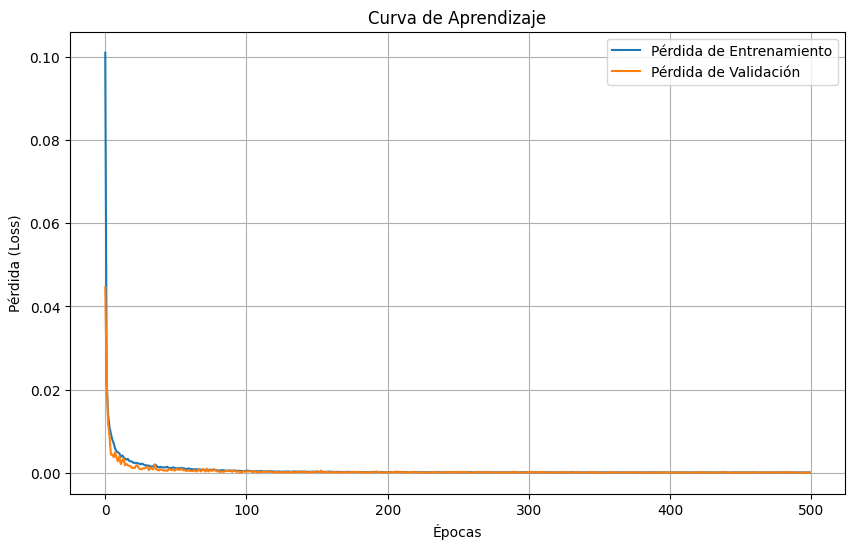

In [10]:
data = pd.read_csv("proyectil_datos.csv")

# Separar características (X) y variables objetivo (y)
X = data[["velocidad", "angulo", "masa", "resistencia"]].values
y = data[["alcance", "altura"]].values


# Escalar los datos
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Crear el modelo
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),  # Definir la entrada explícitamente
        Dense(128),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dense(64),
        LeakyReLU(negative_slope=0.1),
        BatchNormalization(),
        Dense(32),
        LeakyReLU(negative_slope=0.1),
        Dense(2, activation="linear"),
    ]
)

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"]
)

# Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - relative_error

# Desescalar las predicciones para comparación
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)


# Graficar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.grid()
plt.show()


In [11]:
# Comparar trayectorias reales vs predicciones
def comparar_trayectorias(y_test, y_pred):
    """Genera gráficos de comparación entre trayectorias reales y estimadas."""
    plt.figure(figsize=(10, 6))
    plt.scatter(
        y_test[:, 0],
        y_test[:, 1],
        label="Trayectoria Real",
        alpha=0.6,
        color="blue",
    )
    plt.scatter(
        y_pred[:, 0],
        y_pred[:, 1],
        label="Trayectoria Predicha",
        alpha=0.6,
        color="red",
    )
    plt.xlabel("Alcance (m)")
    plt.ylabel("Altura (m)")
    plt.title("Comparación de Trayectorias: Reales vs Predichas")
    plt.legend()
    plt.grid()
    plt.show()

Error relativo promedio: 6.76%
Precisión del modelo: 93.24%


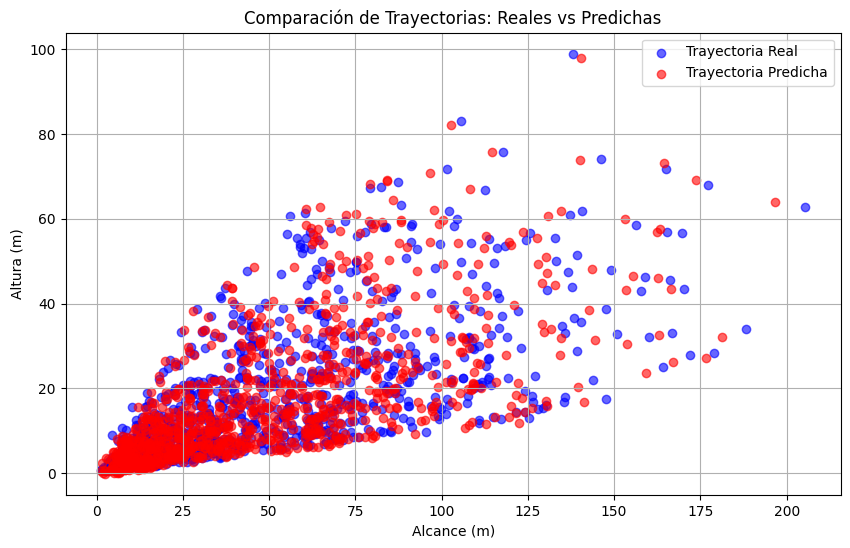

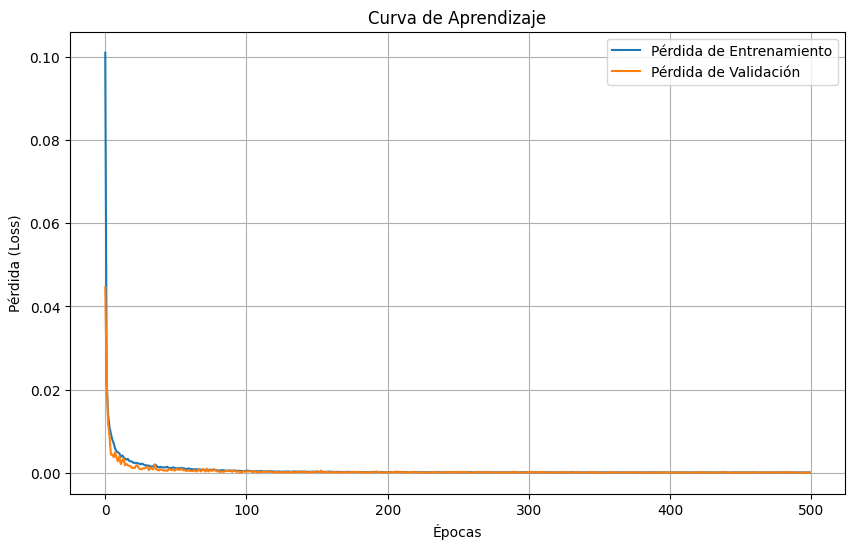

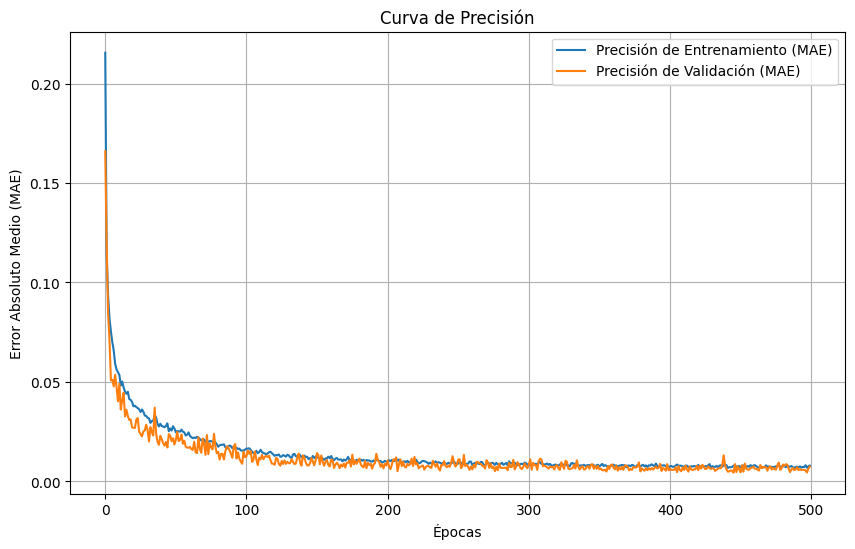

In [12]:
# Calcular error relativo promedio
relative_error = (
    np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
)
accuracy = 100 - relative_error

print(f"Error relativo promedio: {relative_error:.2f}%")
print(f"Precisión del modelo: {accuracy:.2f}%")

comparar_trayectorias(y_test_original, y_pred_original)

# Graficar curva de aprendizaje (pérdida y precisión)
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida de Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], label="Precisión de Entrenamiento (MAE)")
plt.plot(history.history["val_mae"], label="Precisión de Validación (MAE)")
plt.xlabel("Épocas")
plt.ylabel("Error Absoluto Medio (MAE)")
plt.title("Curva de Precisión")
plt.legend()
plt.grid()
plt.show()
